# Librerie

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import torch.nn.init as init
from pathlib import Path

from vae import NpyDataset, VAE, miniVAE, reset_model_weights, vae_loss_function
from utils import load_tile_set, convert_embedding_to_image, plot_images

/home/robivad/.pyenv/versions/3.8.1/envs/cv381/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
# Load data
# data_folder = "dataset"
data_folder = "map_arrays"
dataset = NpyDataset(data_folder)

In [3]:
data_size = len(dataset)
data_size ## should be 128

128

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [5]:
train_data[0].shape ## should be torch.Size([11, 16, 42])

torch.Size([11, 16, 42])

In [6]:
sample_shape = train_data[0].shape
input_dim = torch.prod(torch.tensor(sample_shape)).item()
input_dim

7392

In [7]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Learning Rate

Lowest validation loss of 616.4895 obtained at learning rate 2.8e-02


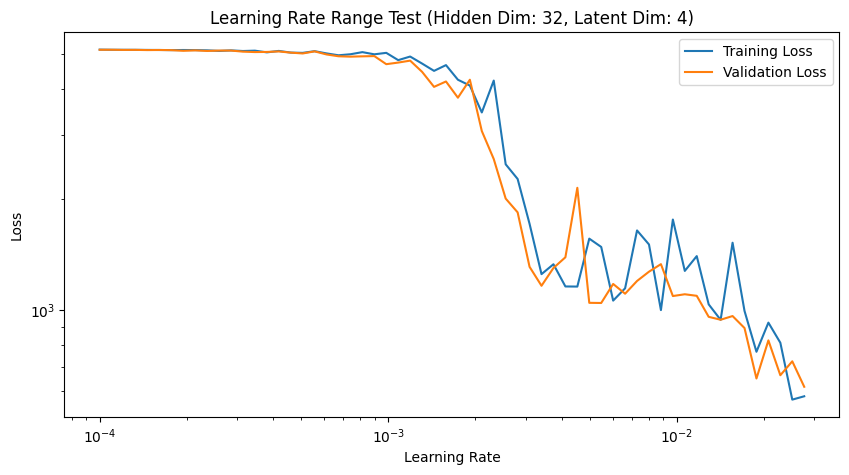


--------------------------------------------------

Lowest validation loss of 397.0857 obtained at learning rate 1.4e-02


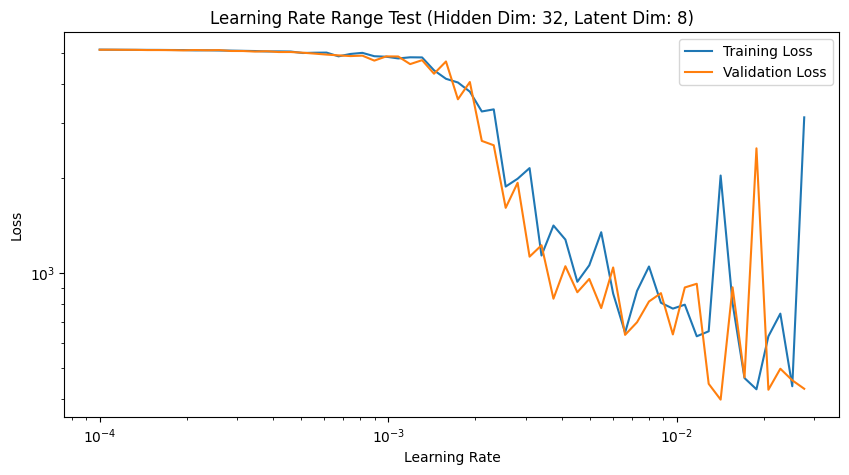


--------------------------------------------------

Lowest validation loss of 601.9650 obtained at learning rate 2.3e-02


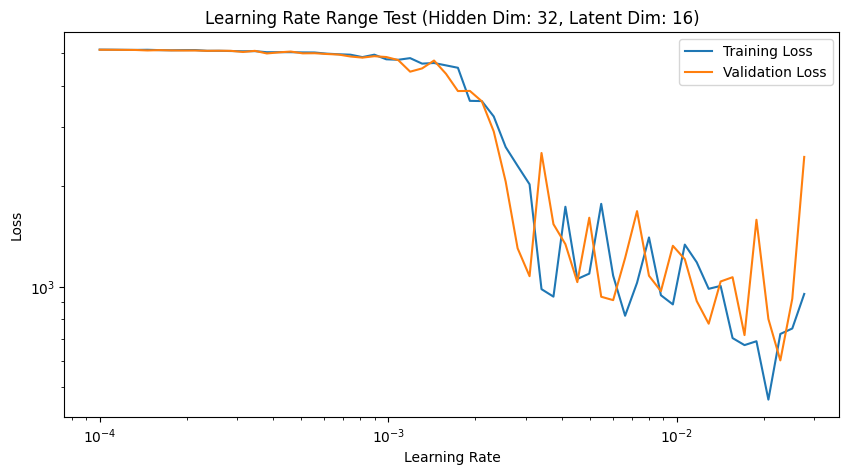


--------------------------------------------------

Lowest validation loss of 482.9223 obtained at learning rate 1.4e-02


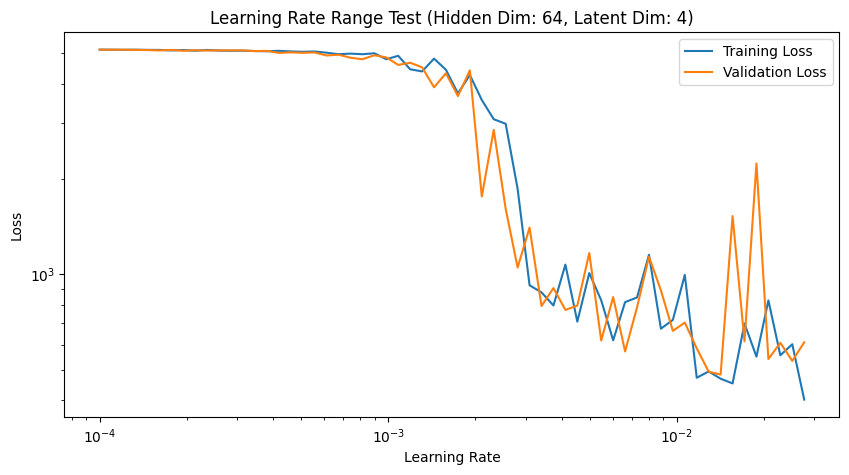


--------------------------------------------------

Lowest validation loss of 328.6505 obtained at learning rate 2.1e-02


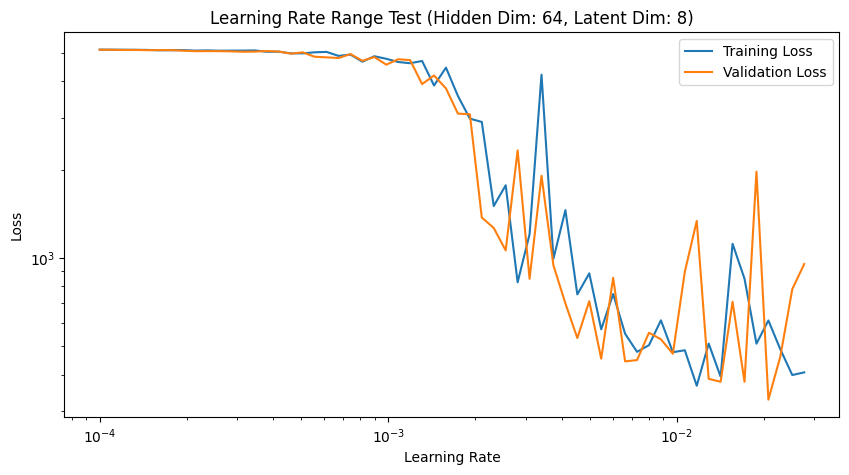


--------------------------------------------------

Lowest validation loss of 442.8098 obtained at learning rate 2.8e-02


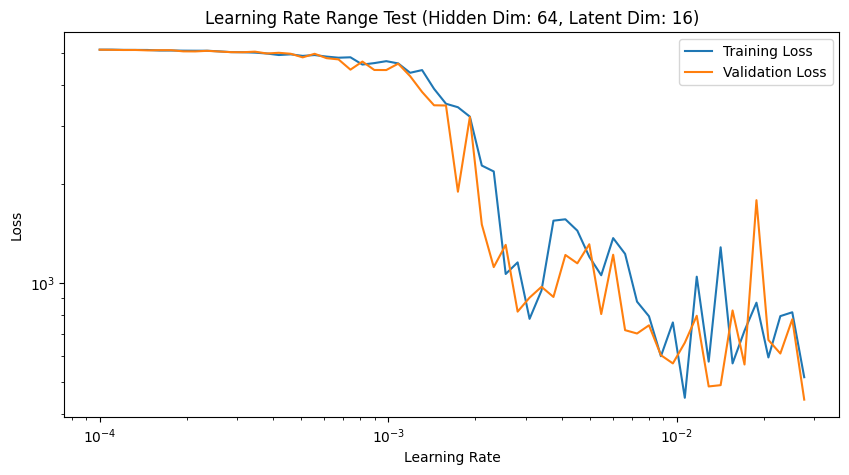


--------------------------------------------------

Lowest validation loss of 414.6877 obtained at learning rate 2.1e-02


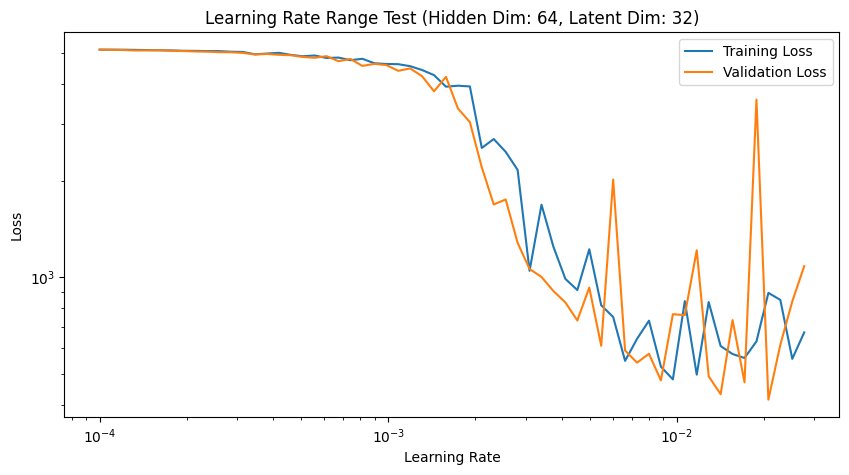


--------------------------------------------------

Lowest validation loss of 325.0882 obtained at learning rate 2.5e-02


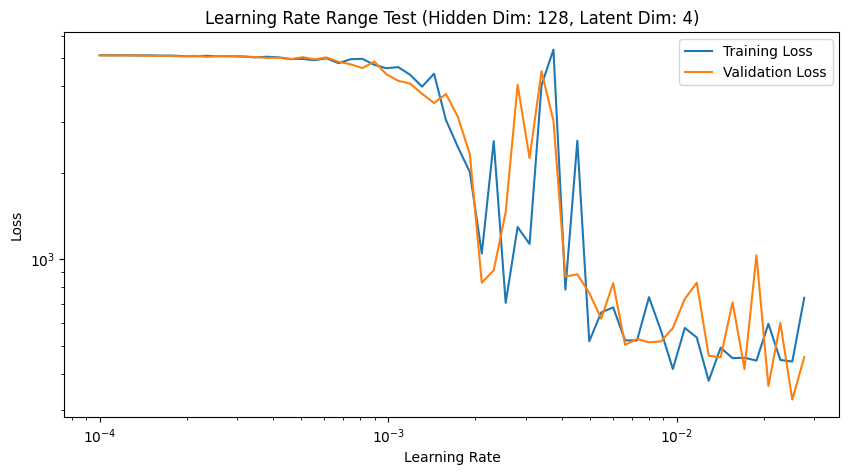


--------------------------------------------------

Lowest validation loss of 393.6960 obtained at learning rate 1.7e-02


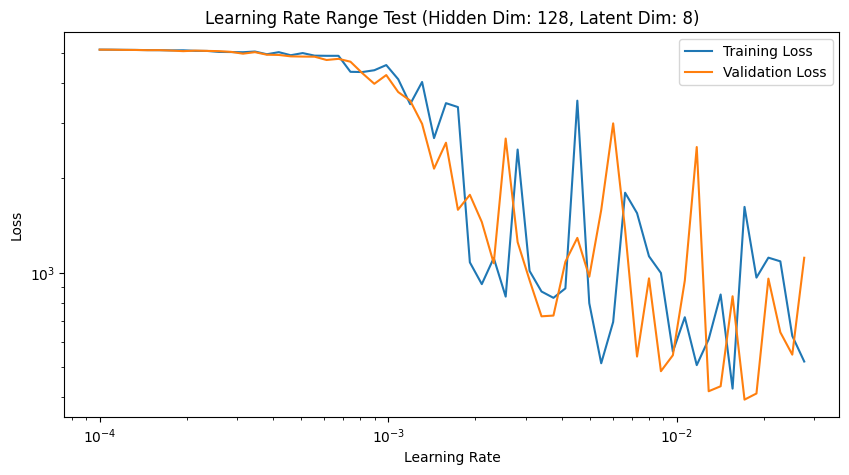


--------------------------------------------------

Lowest validation loss of 486.2569 obtained at learning rate 9.7e-03


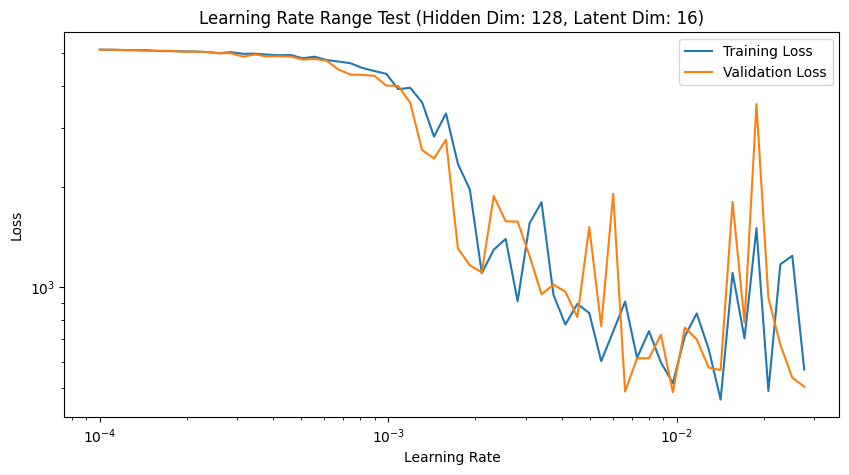


--------------------------------------------------

Lowest validation loss of 459.1124 obtained at learning rate 6.6e-03


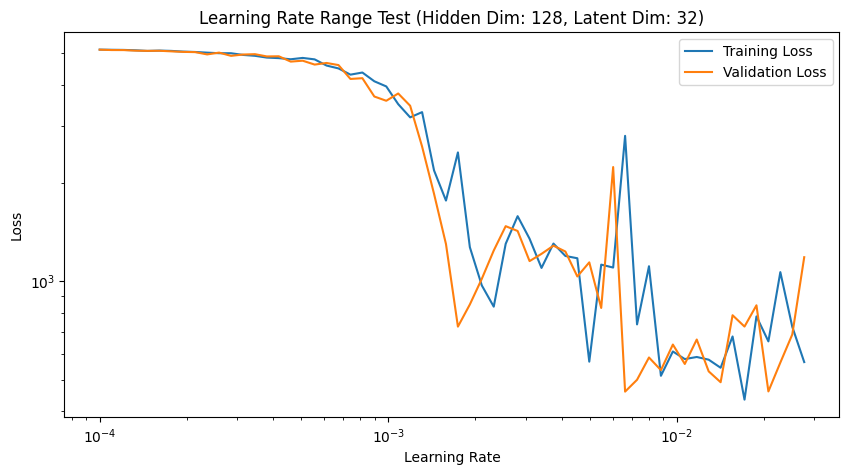


--------------------------------------------------

Lowest validation loss of 455.4969 obtained at learning rate 2.8e-02


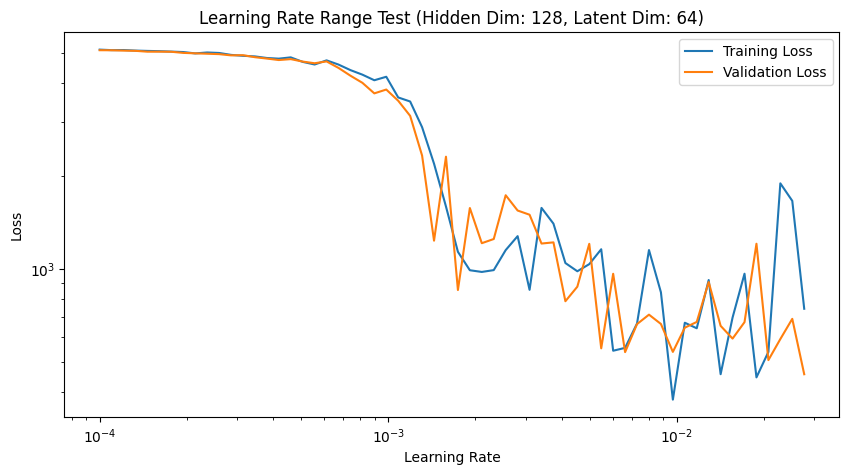


--------------------------------------------------

Lowest validation loss of 488.1958 obtained at learning rate 8.8e-03


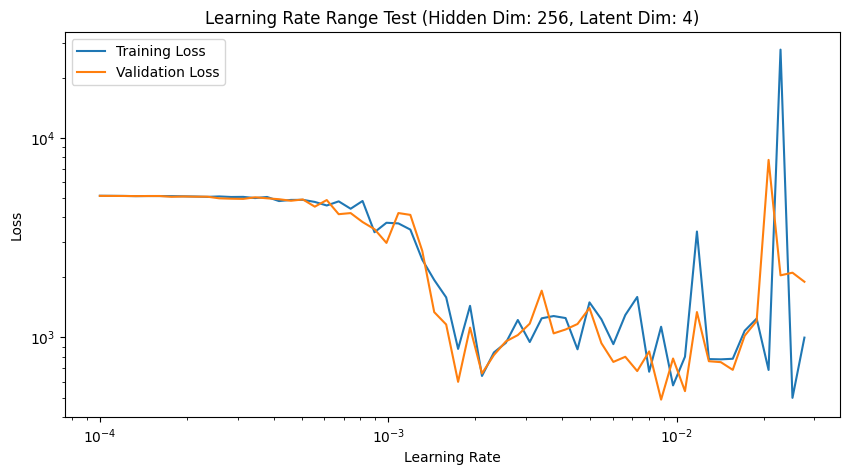


--------------------------------------------------

Lowest validation loss of 402.6974 obtained at learning rate 1.3e-02


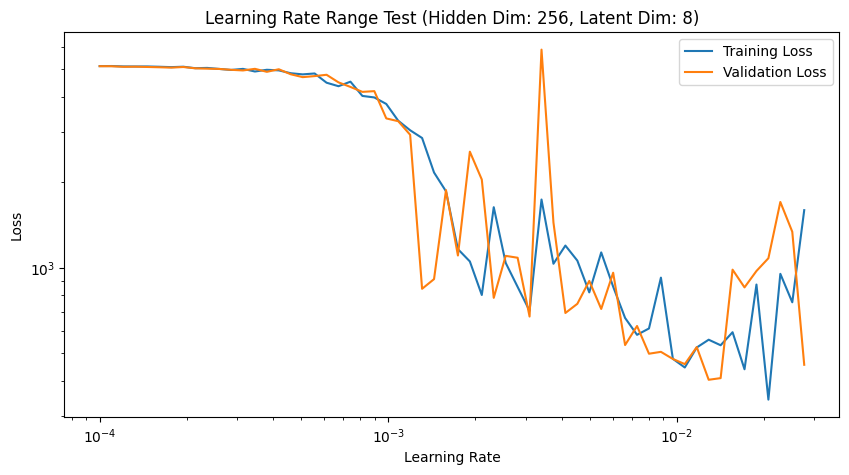


--------------------------------------------------

Lowest validation loss of 439.3660 obtained at learning rate 2.1e-02


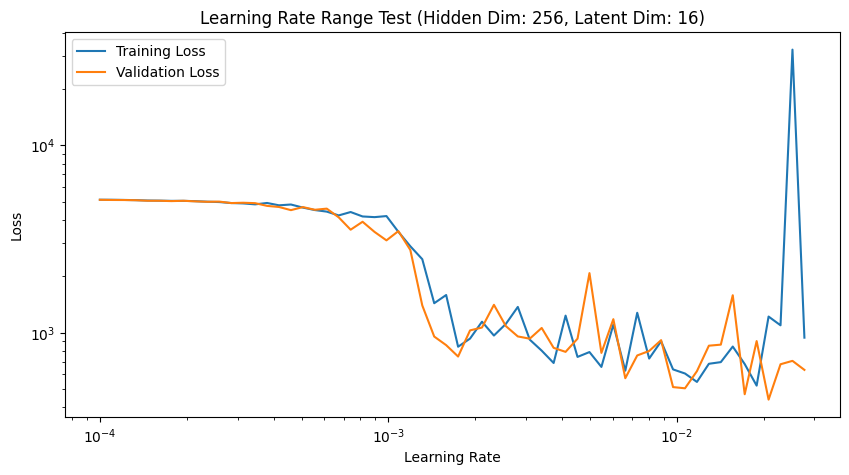


--------------------------------------------------

Lowest validation loss of 460.1492 obtained at learning rate 1.3e-02


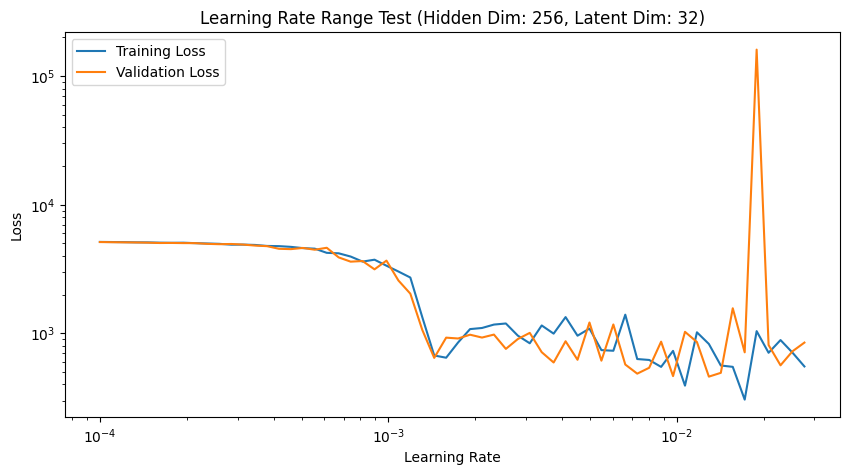


--------------------------------------------------

Lowest validation loss of 407.4593 obtained at learning rate 1.4e-02


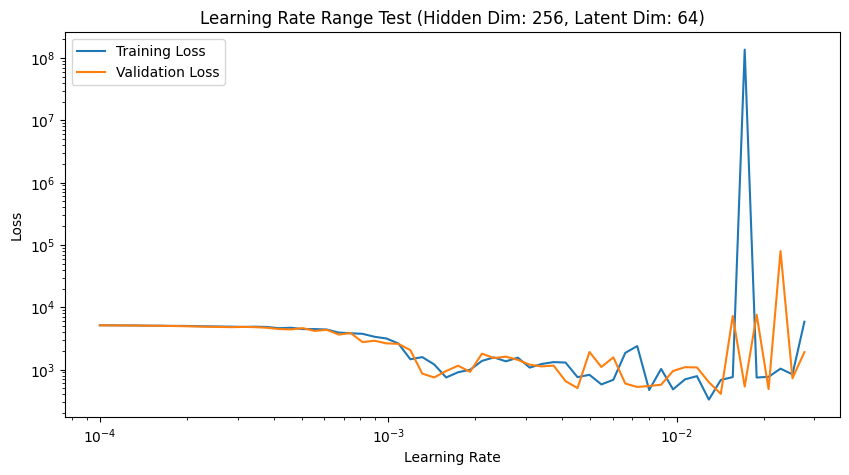


--------------------------------------------------

Lowest validation loss of 421.6868 obtained at learning rate 8.8e-03


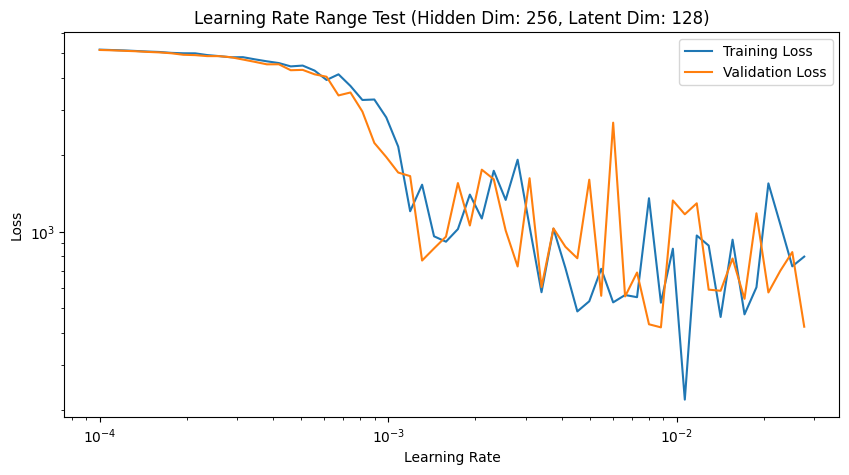


--------------------------------------------------

Lowest validation loss of 406.8511 obtained at learning rate 6.6e-03


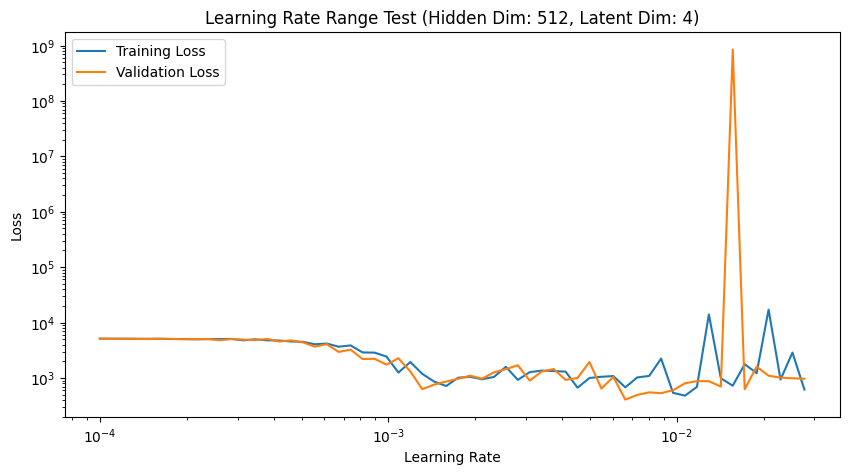


--------------------------------------------------

Lowest validation loss of 345.9446 obtained at learning rate 2.5e-02


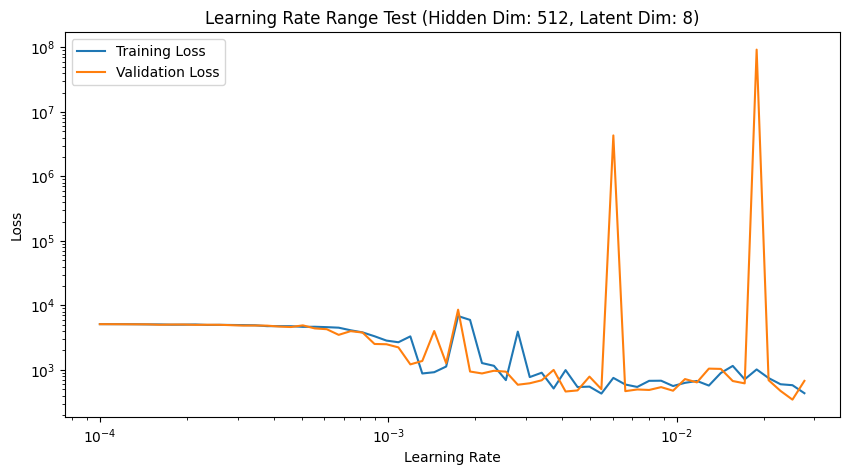


--------------------------------------------------

Lowest validation loss of 441.6779 obtained at learning rate 4.1e-03


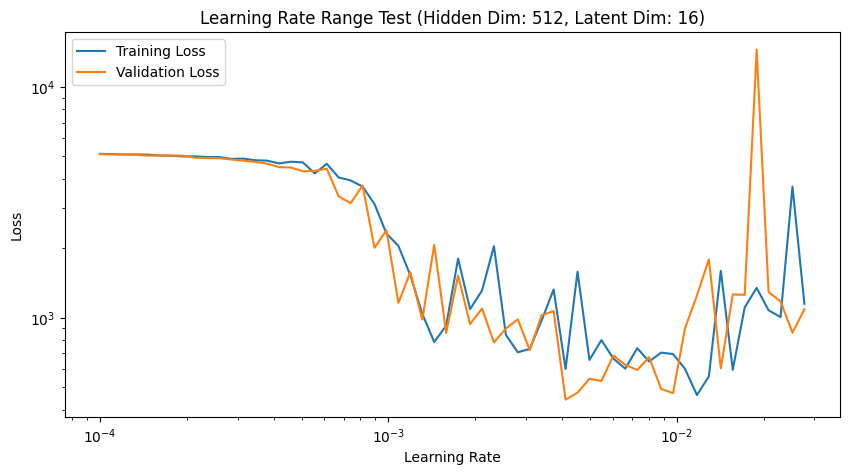


--------------------------------------------------

Lowest validation loss of 371.3651 obtained at learning rate 8.0e-03


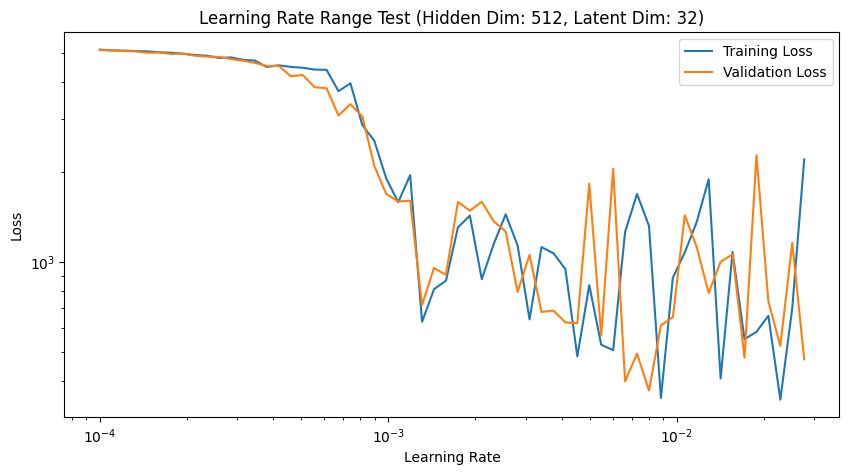


--------------------------------------------------

Lowest validation loss of 441.2823 obtained at learning rate 4.5e-03


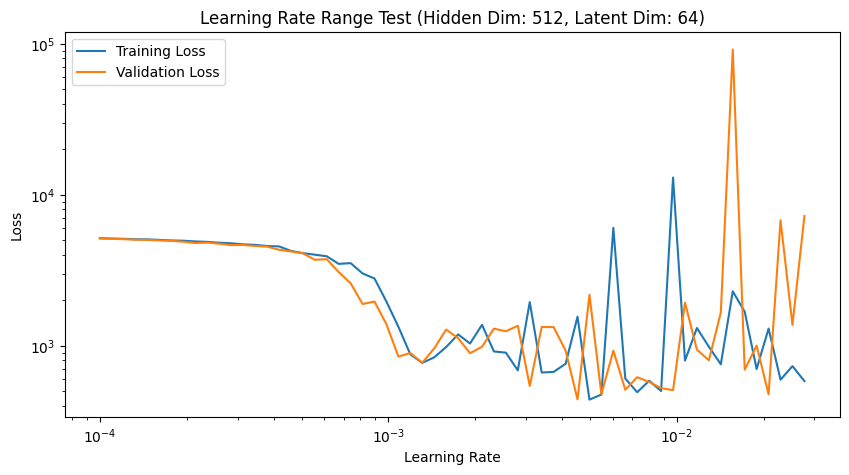


--------------------------------------------------

Lowest validation loss of 448.3471 obtained at learning rate 1.7e-02


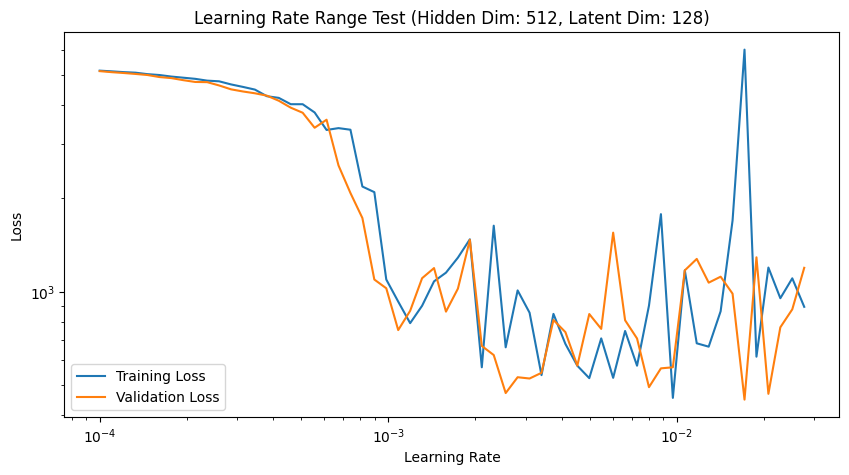


--------------------------------------------------



In [9]:
hidden_layer_sizes = [32, 64, 128, 256, 512]
latent_dim_sizes = [4, 8, 16, 32, 64, 128]

best_hidden_dim = None

for hidden_dim in hidden_layer_sizes:
    for latent_dim in latent_dim_sizes:
        if latent_dim >= hidden_dim:
            continue 
        
        # Instantiate the VAE model
        model = miniVAE(input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
        model = reset_model_weights(model)

        # Initialize optimizer with a very small learning rate
        initial_lr = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=initial_lr)

        # Initialize lists to store learning rates, training losses, and validation losses
        lrs = []
        train_losses = []
        val_losses = []

        # Initialize variables to store the best loss and corresponding learning rate
        min_val_loss = float('inf')
        best_lr = initial_lr

        # Define the learning rate scheduler to exponentially increase the learning rate
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)

        # Number of iterations for the LR range test
        num_iters = 5  # or a reasonable number of iterations

        model.train()
        for iter in range(num_iters):
            for train_batch, val_batch in zip(train_dataloader, val_dataloader):
                # Move batches to GPU
                train_batch = train_batch.to(device)
                val_batch = val_batch.to(device)
                
                optimizer.zero_grad()
                
                # Training phase
                train_outputs, train_mu, train_logvar = model(train_batch)
                train_loss = vae_loss_function(train_outputs, train_batch, train_mu, train_logvar)
                train_loss.backward()
                optimizer.step()
                
                # Validation phase
                model.eval()  # switch to evaluation mode
                with torch.no_grad():
                    val_outputs, val_mu, val_logvar = model(val_batch)
                    val_loss = vae_loss_function(val_outputs, val_batch, val_mu, val_logvar)
                
                # Record the current learning rate and losses
                current_lr = optimizer.param_groups[0]['lr']
                lrs.append(current_lr)
                train_losses.append(train_loss.item())
                val_losses.append(val_loss.item())
                
                # Check for the minimum validation loss and corresponding learning rate
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    best_lr = current_lr
                
                # Step the learning rate scheduler
                scheduler.step()
                
                # Print progress
                #print(f"Iter {iter+1}/{num_iters}, LR: {current_lr:.1e}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

        print(f"Lowest validation loss of {min_val_loss:.4f} obtained at learning rate {best_lr:.1e}")
        # Plot the learning rate range test
        plt.figure(figsize=(10, 5))
        plt.plot(lrs, train_losses, label='Training Loss')
        plt.plot(lrs, val_losses, label='Validation Loss')
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.yscale('log')
        plt.ylabel('Loss')
        plt.title(f'Learning Rate Range Test (Hidden Dim: {hidden_dim}, Latent Dim: {latent_dim})')
        plt.legend()
        plt.show()
        print('\n' + '-' * 50 + '\n')


# Training

In [10]:
def generate_model(model, optimizer, num_epochs=300, patience=50, output_model_path='vae.pth'):
    # Initialize lists to store losses
    train_losses = []
    test_losses = []

    best_loss = float('inf')  # Initialize best loss to positive infinity
    best_epoch = 0  # Initialize the epoch at which the best loss occurred

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_dataloader:
            # Move batch to GPU
            batch = batch.to(device)
            
            optimizer.zero_grad()
            outputs, mu, logvar = model(batch)
            loss = vae_loss_function(outputs, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        average_train_loss = train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Evaluate Model
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.to(device)
                outputs, mu, logvar = model(batch)
                test_loss += vae_loss_function(outputs, batch, mu, logvar).item()

        average_test_loss = test_loss / len(test_dataloader)
        test_losses.append(average_test_loss)

        print(f"Epoch {epoch+1}, Average Train Loss: {average_train_loss}, Average Test Loss: {average_test_loss}")

        # Check if the current test loss is the best so far
        if average_test_loss < best_loss:
            best_loss = average_test_loss
            best_epoch = epoch
            # Save the best model
            torch.save(model.state_dict(), output_model_path)

        # Check for early stopping criterion
        if epoch - best_epoch >= patience:
            print(f"No improvement in test loss for {patience} epochs. Early stopping.")
            break
        
    return train_losses, test_losses

In [11]:
tiny_model = miniVAE(input_dim, latent_dim=4, hidden_dim=32).to(device)
tiny_lr = 0.001
tiny_optimizer = optim.Adam(tiny_model.parameters(), lr=tiny_lr)

normal_model = miniVAE(input_dim, latent_dim=32, hidden_dim=256).to(device)
normal_lr = 0.001
normal_optimizer = optim.Adam(normal_model.parameters(), lr=normal_lr)

large_model = miniVAE(input_dim, latent_dim=64, hidden_dim=512).to(device)
large_lr = 0.001
large_optimizer = optim.Adam(large_model.parameters(), lr=large_lr)

In [12]:
tiny_train_losses , tiny_test_losses = generate_model(tiny_model, tiny_optimizer, 300, 50, "mono_tiny_vae.pth")
large_train_losses, large_test_losses = generate_model(large_model, large_optimizer, 300, 50, "mono_large_vae.pth")
normal_train_losses, normal_test_losses = generate_model(normal_model, normal_optimizer, 300, 50, "mono_normal_vae.pth")

Epoch 1, Average Train Loss: 1908.0761631984337, Average Test Loss: 530.6394195556641
Epoch 2, Average Train Loss: 520.20809098786, Average Test Loss: 462.94944545200894
Epoch 3, Average Train Loss: 472.1508950626149, Average Test Loss: 435.82462637765065
Epoch 4, Average Train Loss: 448.2938235413794, Average Test Loss: 409.4538378034319
Epoch 5, Average Train Loss: 436.23629042681523, Average Test Loss: 388.5609021868025
Epoch 6, Average Train Loss: 404.8367345473346, Average Test Loss: 358.86317661830356
Epoch 7, Average Train Loss: 369.5644146788354, Average Test Loss: 329.58129446847096
Epoch 8, Average Train Loss: 336.9184096093271, Average Test Loss: 313.9305627005441
Epoch 9, Average Train Loss: 316.1471580056583, Average Test Loss: 304.51778520856584
Epoch 10, Average Train Loss: 300.7283779967065, Average Test Loss: 299.41299220493863
Epoch 11, Average Train Loss: 288.1259849398744, Average Test Loss: 292.7398703438895
Epoch 12, Average Train Loss: 276.8155145084157, Average 

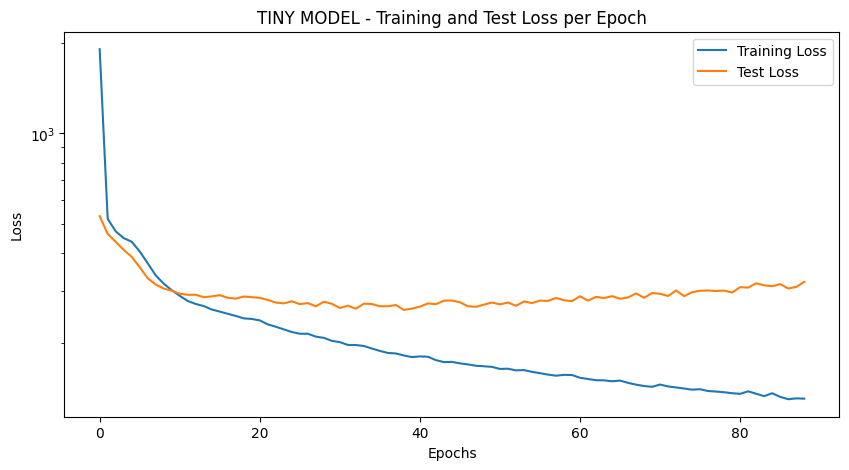

In [13]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(tiny_train_losses, label='Training Loss')
plt.plot(tiny_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('TINY MODEL - Training and Test Loss per Epoch')
plt.show()

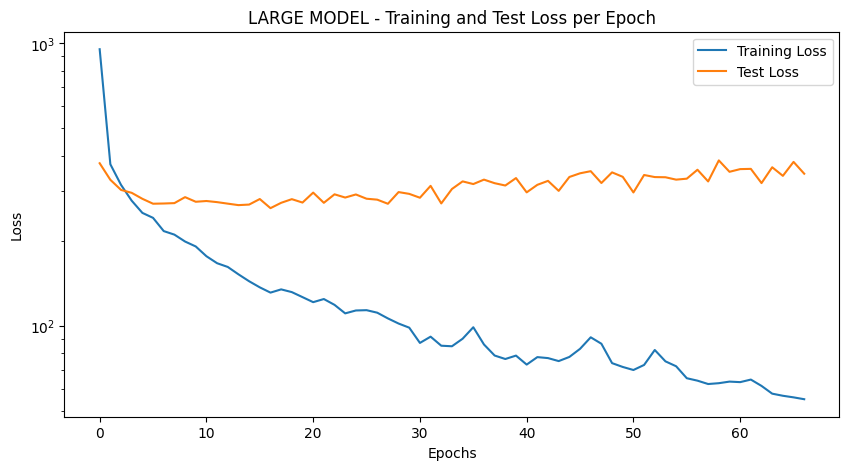

In [14]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(large_train_losses, label='Training Loss')
plt.plot(large_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('LARGE MODEL - Training and Test Loss per Epoch')
plt.show()

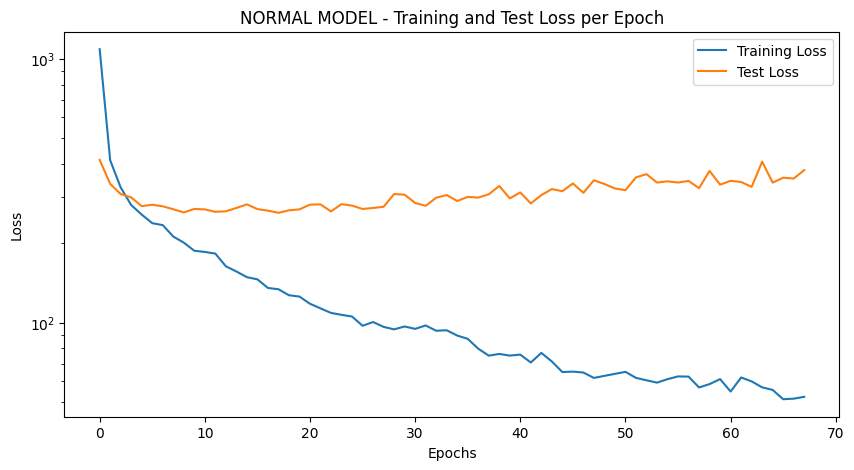

In [15]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(normal_train_losses, label='Training Loss')
plt.plot(normal_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('NORMAL MODEL - Training and Test Loss per Epoch')
plt.show()

# Reconstruction

In [16]:
tile_set = load_tile_set()
len(tile_set) # should be 42

42

In [17]:
tiny_model = miniVAE(input_dim, latent_dim=4, hidden_dim=32).to(device)
tiny_model.load_state_dict(torch.load('mono_tiny_vae.pth'))

normal_model = miniVAE(input_dim, latent_dim=32, hidden_dim=256).to(device)
normal_model.load_state_dict(torch.load('mono_normal_vae.pth'))

large_model = miniVAE(input_dim, latent_dim=64, hidden_dim=512).to(device)
large_model.load_state_dict(torch.load('mono_large_vae.pth'))

<All keys matched successfully>

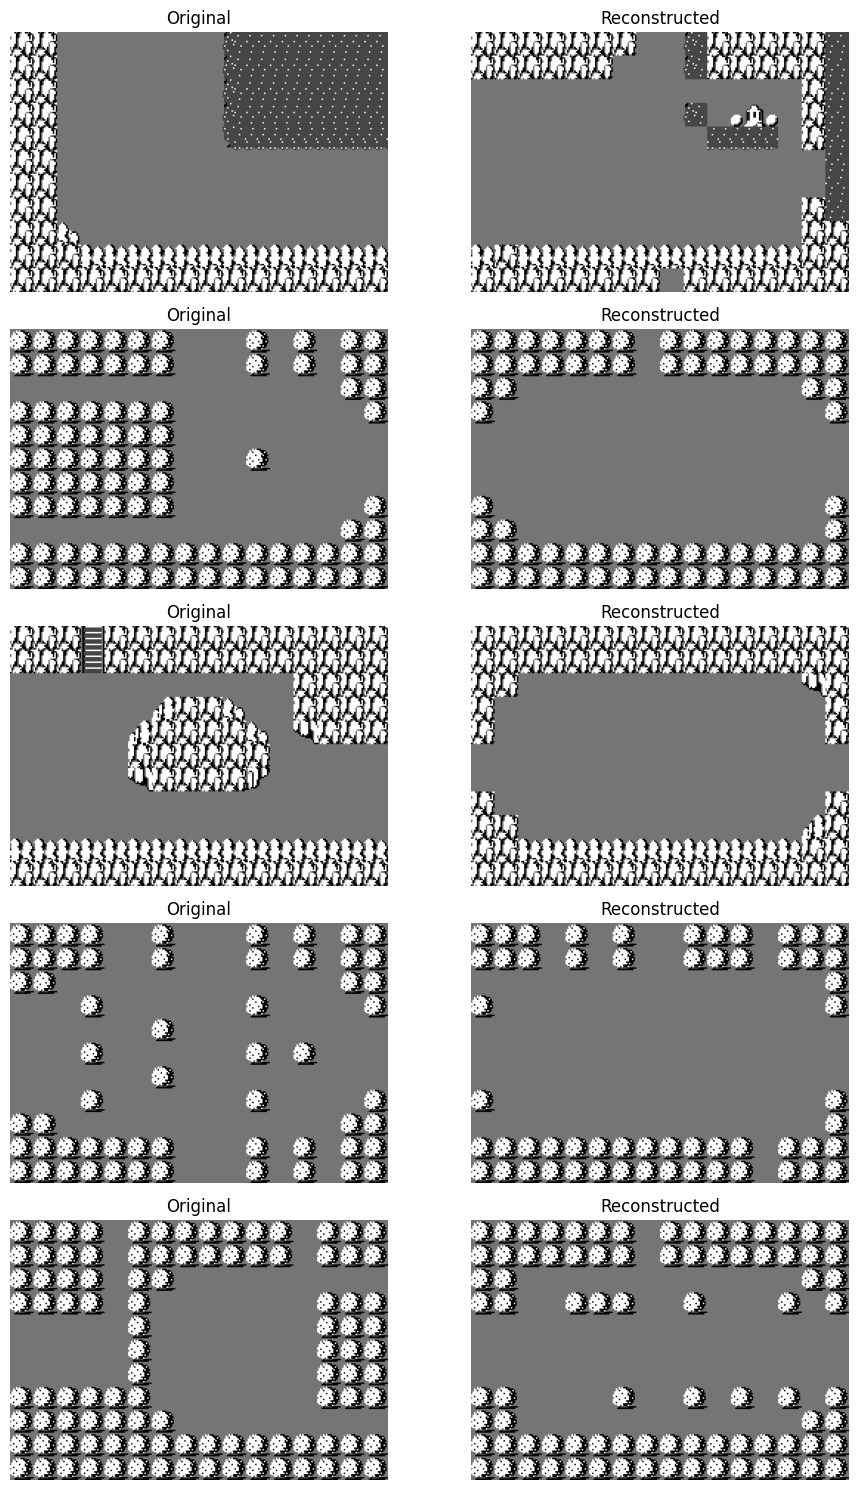

In [18]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
tiny_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = tiny_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)


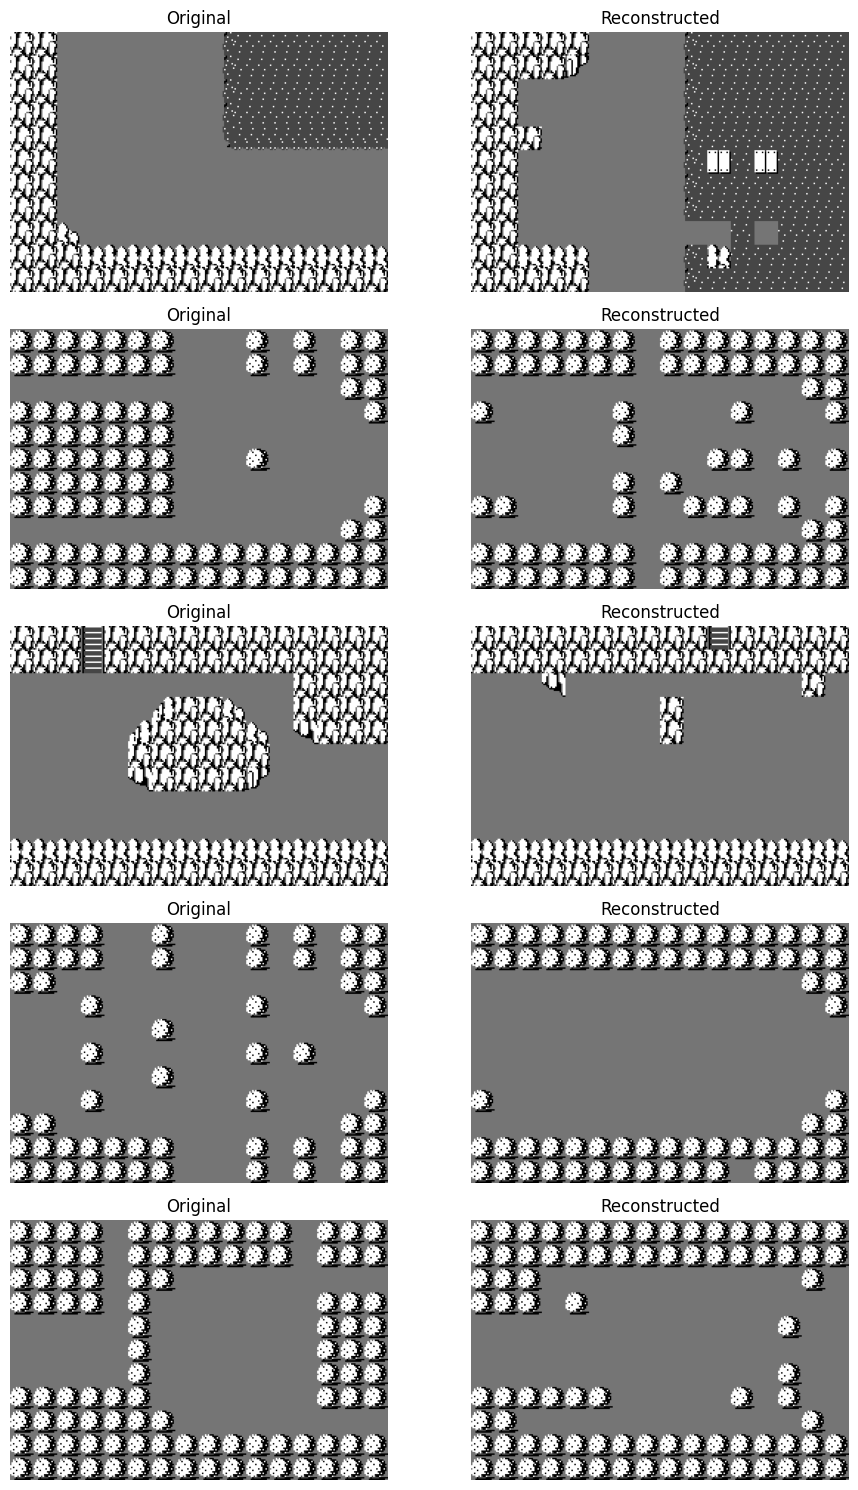

In [19]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
large_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = large_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)



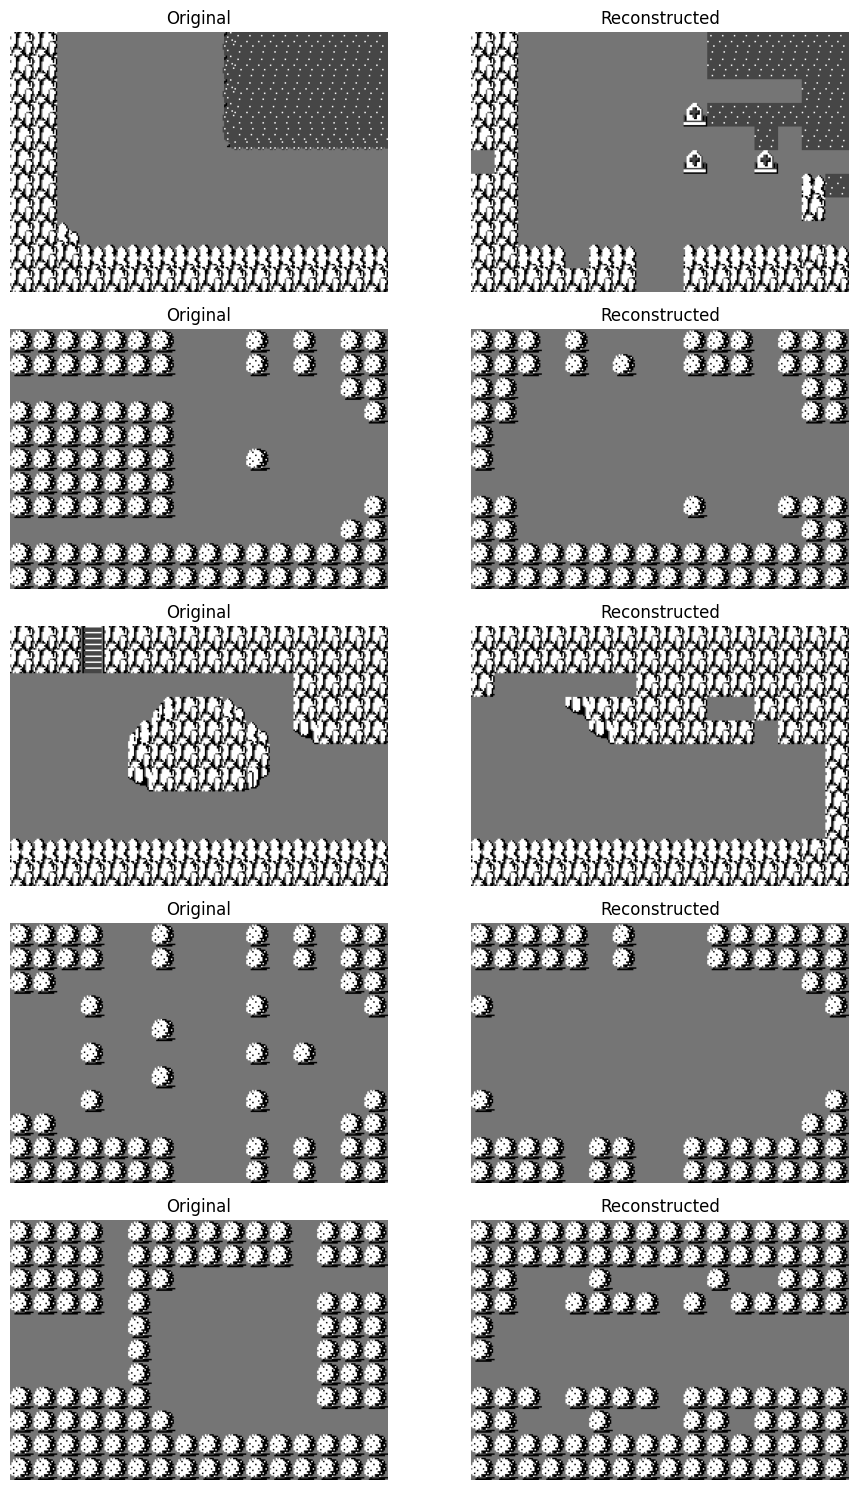

In [20]:
# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
normal_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = normal_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images, tile_set, 16)

# Generation

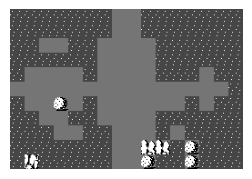

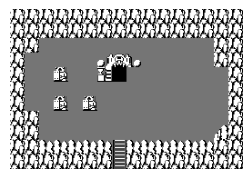

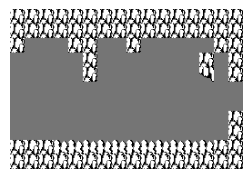

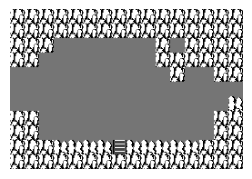

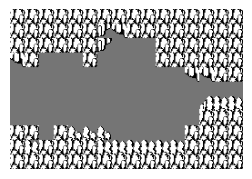

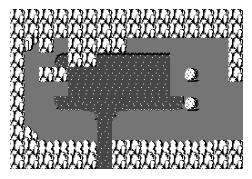

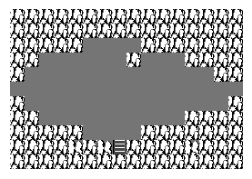

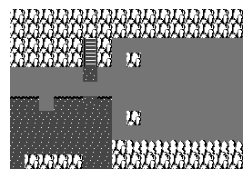

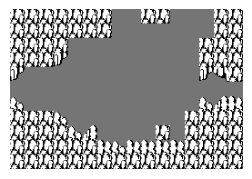

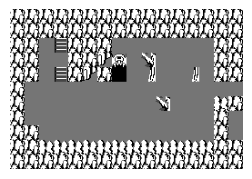

/tmp/ipykernel_105084/946474040.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3))


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [35]:
# Set the VAE model to evaluation mode
normal_model.eval()
latent_dim=32
tile_size = 16

# Number of samples to generate
num_samples = 128

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = normal_model.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

output_dir = "generated_sample/normal"
os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

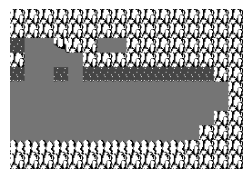

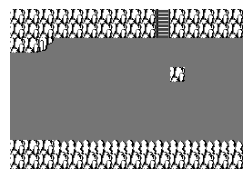

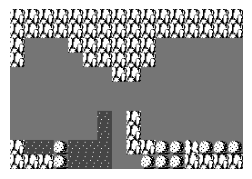

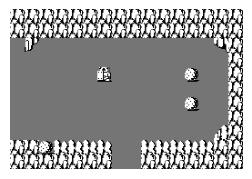

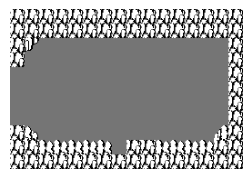

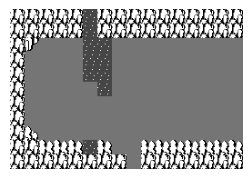

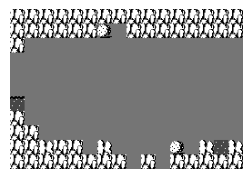

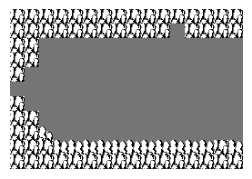

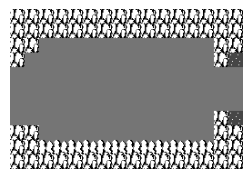

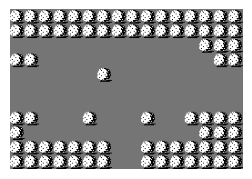

/tmp/ipykernel_105084/2154054519.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3))


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [34]:
# normal_model = miniVAE(input_dim, latent_dim=32, hidden_dim=256).to(device)
# normal_model.load_state_dict(torch.load('mono_normal_vae.pth'))

# Set the VAE model to evaluation mode
large_model.eval()
latent_dim=64
tile_size = 16

# Number of samples to generate
num_samples = 128

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = large_model.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

output_dir = "generated_sample/large"
os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

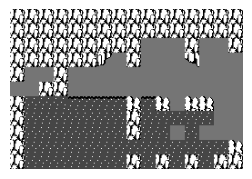

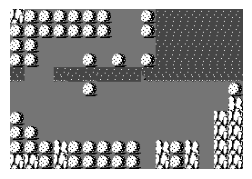

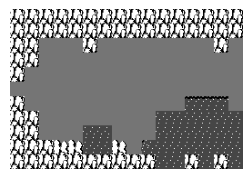

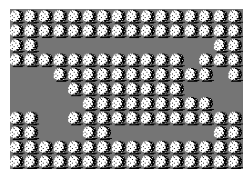

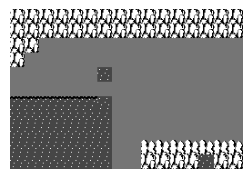

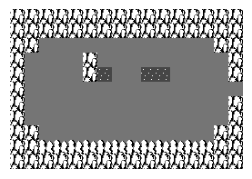

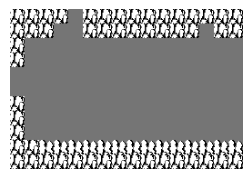

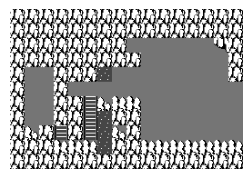

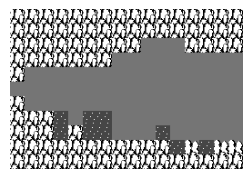

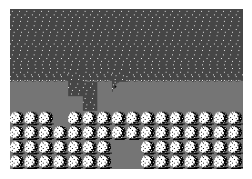

/tmp/ipykernel_105084/4045624858.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3))


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [36]:
# normal_model = miniVAE(input_dim, latent_dim=32, hidden_dim=256).to(device)
# normal_model.load_state_dict(torch.load('mono_normal_vae.pth'))

# Set the VAE model to evaluation mode
tiny_model.eval()
latent_dim=4
tile_size = 16

# Number of samples to generate
num_samples = 128

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = tiny_model.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

output_dir = "generated_sample/tiny"
os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

In [41]:
from torchviz import make_dot

# Create a model instance
input_dim = 11 * 16 * 42
latent_dim = 32
hidden_dim = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = miniVAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)

# Load the model state
model.load_state_dict(torch.load('mono_normal_vae.pth', map_location=device))

# Create a sample input tensor with the correct shape
sample_input = torch.randn(1, 11, 16, 42).to(device)

# Pass the sample input through the model
output, mean, logvar = model(sample_input)

# Generate a visualization of the model
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render("miniVAE_architecture_detailed", format="png")

'miniVAE_architecture_detailed.png'

In [42]:
from torchviz import make_dot

# Create a model instance
input_dim = 11 * 16 * 42
latent_dim = 32
hidden_dim = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = miniVAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)

# Load the model state
model.load_state_dict(torch.load('mono_normal_vae.pth', map_location=device))

# Create a sample input tensor with the correct shape
sample_input = torch.randn(1, 11, 16, 42).to(device)

# Pass the sample input through the model
output, mean, logvar = model(sample_input)

# Generate a visualization of the model
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("miniVAE_architecture", format="png")

TypeError: make_dot() got an unexpected keyword argument 'graph_attr'